In [3]:
from math import log
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from matching import neg_log_bayes, miqcp
# from gurobi import GRB, Model, quicksum
import pandas as pd
import time
from matching import (
    run_cop_kmeans, 
    run_kmeans, 
    setup_dirilp, 
    dirilp, 
    find_max_clusters, 
    setup_miqcp_model, 
    neg_log_bayes,
    plot_lined,
    chain_breaking
    )
import itertools

plt.rcParams['text.usetex'] = True

In [37]:
def simulate_two_objects(sigma1: float = 0.04, 
                         sigma2: float = 0.04, 
                         distance:float = 0.04, 
                         num: int = 10, 
                         seed = 0):
    """Simulate two overlapping objects.

    Args:
        sigma1 (float, optional): Sigma to use for first object. Defaults to 0.04.
        sigma2 (float, optional): Sigma to use for second object. Defaults to 0.04.
        distance (float, optional): distance between center of objects. Defaults to 0.04.
        num (int, optional): number of sources to generate for each object. Defaults to 10.
    """
    np.random.seed(seed)
    center1 = np.array([-distance / 2, 0])
    center2 = np.array([distance / 2, 0])

    sources1 = np.random.multivariate_normal(center1, np.eye(2) * (sigma1**2), (num))
    sources2 = np.random.multivariate_normal(center2, np.eye(2) * (sigma2**2), (num))

    # imageIDs = [0] * (2 * num)
    imageIDs = [0] * (1 * num)
    for i in range(num):
        imageIDs[i] = i
        # imageIDs[i+num] = i
        
    sigmas = ([sigma1] * num) # + ([sigma2] * num)
    # coords = np.vstack((sources1, sources2))
    coords = sources1
    df_dict = {"ImageID": imageIDs, 
               "Sigma": sigmas,
               "coord1 (arcseconds)": coords.T[0],
               "coord2 (arcseconds)": coords.T[1]}
    df = pd.DataFrame(df_dict)
    df["kappa"] = df["Sigma"] ** (-2)
    df["SourceID"] = df.index
    df["ObjectID"] = ([0] * num) # + ([1] * num)

    return df

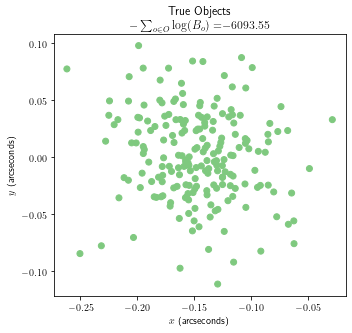

In [39]:
cats = 200
sigma1 = 0.04
sigma2 = 0.04
distance = 0.3
seed = 1

df = simulate_two_objects(sigma1 = sigma1, sigma2 = sigma2, distance=distance, num=cats, seed = seed)
plt.figure(figsize=(5,5))
plt.title("True Objects\n"
            r"$-\sum_{{o\in O}}\log(B_o)=$"
            f"${neg_log_bayes(df,df.ObjectID):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(df["coord1 (arcseconds)"], df["coord2 (arcseconds)"],c=df.ObjectID,cmap='Accent')
plt.tight_layout()
ax = plt.gca()
ax.set_aspect('equal')
# plt.savefig(f"figures/presentation/true_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

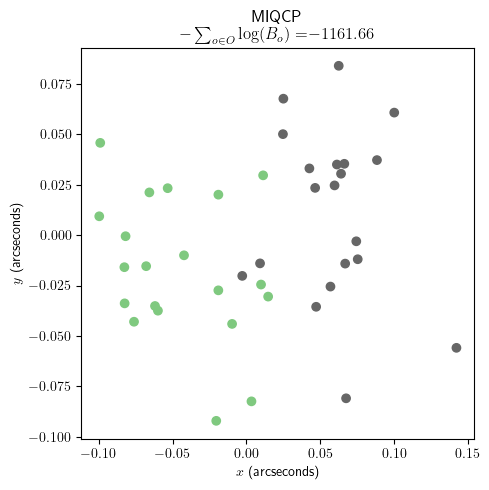

In [10]:
labels = miqcp(data_df = df, verbose = False, preDual = False, preQLinearize = False)

plt.figure(figsize=(5,5))
plt.title("MIQCP\n"
            r"$-\sum_{{o\in O}}\log(B_o)=$"
            f"${neg_log_bayes(df,labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(df["coord1 (arcseconds)"], df["coord2 (arcseconds)"],c=labels,cmap='Accent')
plt.tight_layout()
ax = plt.gca()
ax.set_aspect('equal')
# plt.savefig(f"figures/presentation/miqcp_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

In [13]:
labels, _,_ = chain_breaking(df)

plt.figure(figsize=(5,5))
plt.title("Chain-Breaking\n"
            r"$-\sum_{{o\in O}}\log(B_o)=$"
            f"${neg_log_bayes(df,labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(df["coord1 (arcseconds)"], df["coord2 (arcseconds)"],c=labels,cmap='Accent')
plt.tight_layout()
ax = plt.gca()
ax.set_aspect('equal')
# plt.savefig(f"figures/presentation/chain-breaking_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

KeyboardInterrupt: 

In [42]:
from tqdm import tqdm
from sklearn.cluster import KMeans

from functools import cache
import math

@cache
def sterling2(n, k):
	if n == k == 0:
		return 1
	if (n > 0 and k == 0) or (n == 0 and k > 0):
		return 0
	if n == k:
		return 1
	if k > n:
		return 0
	result = k * sterling2(n - 1, k) + sterling2(n - 1, k - 1)
	return result

def run_kmeans2(data_df: pd.DataFrame, min_k: int, max_k: int):
    coords = data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
    weights = data_df["kappa"]

    best_labels = None
    best_k = 0
    best_bayes = np.Inf

    for k in tqdm(range(min_k,max_k)):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init = 100).fit(X = coords, sample_weight=weights)
        bayes = neg_log_bayes(data_df, kmeans.labels_)
	
        bayes += math.log(sterling2(data_df.shape[0], k))

        if bayes < best_bayes:
            best_bayes = bayes
            best_labels = kmeans.labels_
            best_k = k
    return best_labels, best_k, best_bayes

100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


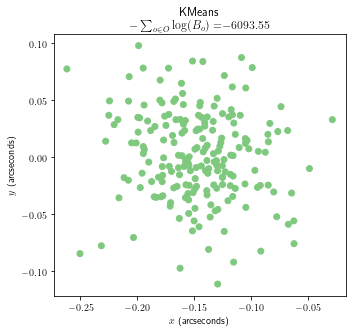

In [43]:
labels, _,_ = run_kmeans2(df, min_k = 1, max_k = 10)

plt.figure(figsize=(5,5))
plt.title("KMeans\n"
            r"$-\sum_{{o\in O}}\log(B_o)=$"
            f"${neg_log_bayes(df,labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(df["coord1 (arcseconds)"], df["coord2 (arcseconds)"],c=labels,cmap='Accent')
plt.tight_layout()
ax = plt.gca()
ax.set_aspect('equal')

In [14]:
labels, _,_ = run_cop_kmeans(df, min_k = 1, max_k = 10, num_repeat = 1, verbose = True)

plt.figure(figsize=(5,5))
plt.title("COP-KMeans\n"
            r"$-\sum_{{o\in O}}\log(B_o)=$"
            f"${neg_log_bayes(df,labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(df["coord1 (arcseconds)"], df["coord2 (arcseconds)"],c=labels,cmap='Accent')
plt.tight_layout()
ax = plt.gca()
ax.set_aspect('equal')
# plt.savefig(f"figures/presentation/cop-kmeans_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

  0%|          | 0/1 [02:21<?, ?it/s]


KeyboardInterrupt: 

In [5]:
cats = 30
sigma1 = 0.04
sigma2 = 0.04
distance = 0.13
seed = 1

df = simulate_two_objects(sigma1 = sigma1, sigma2 = sigma2, distance=distance, num=cats, seed = seed)

In [3]:
from functools import partial
from typing import Union
from func_timeout import func_timeout, FunctionTimedOut

def time_method(df: pd.DataFrame, method, repeat: int = 1):
    """ Time a method.

    Args:
        df (pd.DataFrame): dataframe with coordinates and uncertainties
        method (function): method to run
        repeat (int, optional): number of time repeats. Defaults to 5.

    Returns:
        list: list of runtimes
    """
    times = []
    
    for _ in range(repeat):
        time_spent = 0
        try:
            start_time = time.perf_counter()

            func_timeout(2700,method,args=(df,))
            end_time = time.perf_counter()
            time_spent = end_time - start_time
        except FunctionTimedOut:
            time_spent = 1000000000

        times.append(time_spent)
    return times

def log_runtimes(filename: str,
                 distances: Union[list[float], float], 
                 num_cats: Union[list[float], float], 
                 sigma1s: Union[list[float], float], 
                 sigma2s: Union[list[float], float],
                 repeats: int):
    pd_dict = {
        "distance": [],
        "number of catalogs": [],
        "sigma 1": [],
        "sigma 2": [],
        "miqcp runtimes": [],
        "dirilp runtimes": []
    }
    if type(distances) == float:
        distances = [distances]
    if type(num_cats) == float:
        num_cats = [num_cats]
    if type(sigma1s) == float:
        sigma1s = [sigma1s]
    if type(sigma2s) == float:
        sigma2s = [sigma2s]
    for d, n, s1, s2 in itertools.product(distances,num_cats,sigma1s,sigma2s):
        print(d,n,s1,s2)
        pd_dict["distance"].append(d)
        pd_dict["number of catalogs"].append(n)
        pd_dict["sigma 1"].append(s1)
        pd_dict["sigma 2"].append(s2)
        miqcp_times = []
        dirilp_times = []
        for seed in range(repeats):
            df = simulate_two_objects(sigma1 = s1, sigma2 = s2, distance=d, num=n, seed = seed)
            miqcp_time = time_method(df, miqcp, repeat = 1)
            dirilp_time = time_method(df, dirilp, repeat = 1)
            miqcp_times.append(miqcp_time[0])
            dirilp_times.append(dirilp_time[0])
        pd_dict["miqcp runtimes"].append(miqcp_times)
        pd_dict["dirilp runtimes"].append(dirilp_times)
    
    df_times = pd.DataFrame(pd_dict)
    df_times.to_csv(filename)

In [5]:
log_runtimes("runtimes3.csv", 0.13, [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 0.04, 0.04, 5)

0.13 2 0.04 0.04
0.13 5 0.04 0.04
0.13 10 0.04 0.04
0.13 15 0.04 0.04
0.13 20 0.04 0.04
0.13 25 0.04 0.04


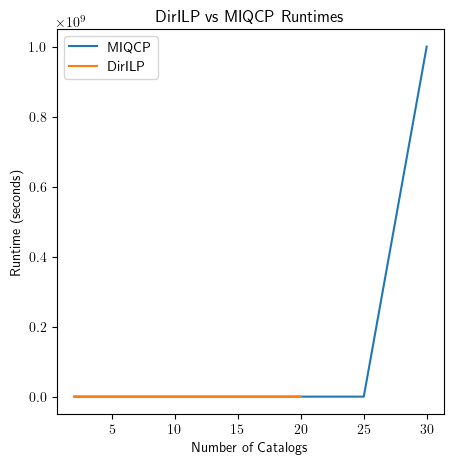

In [40]:
runtimes = pd.read_csv("runtimes2.csv")
times = runtimes["miqcp runtimes"]
miqcp_runtimes = [t.strip('][').split(', ') for t in times]
miqcp_runtimes = [float(t[0]) for t in miqcp_runtimes]

times = runtimes["dirilp runtimes"]
dirilp_runtimes = [t.strip('][').split(', ') for t in times]
dirilp_runtimes = [float(t[0]) for t in dirilp_runtimes]

for i in range(len(dirilp_runtimes)):
    if dirilp_runtimes[i] == 1000000000:
        dirilp_runtimes[i] = np.nan

plt.figure(figsize=(5,5))
plt.title("DirILP vs MIQCP Runtimes")
plt.plot(runtimes["number of catalogs"], miqcp_runtimes)
plt.plot(runtimes["number of catalogs"], dirilp_runtimes)
plt.legend(["MIQCP", "DirILP"])
plt.xlabel("Number of Catalogs")
plt.ylabel("Runtime (seconds)")
plt.savefig("runtime_long.svg")

In [2]:
def get_percent_solved(arr):
    count = 0
    for a in arr:
        if a == 1000000000:
            count += 1
    return 100 * (1 - (count / len(arr)))

def filtered_mean_std(arr):
    arr = np.array(arr)
    arr = np.delete(arr, np.where(arr == 1000000000))
    return np.mean(arr), np.std(arr)

In [39]:
runtimes_long = pd.read_csv("runtimes3.csv", index_col=0)
cat_list = runtimes_long["number of catalogs"].unique()
miqcp_runtimes = runtimes_long.groupby('number of catalogs')["miqcp runtime"].apply(list).to_dict()
dirilp_runtimes = runtimes_long.groupby('number of catalogs')["dirilp runtime"].apply(list).to_dict()

miqcp_percent_solved = {k:get_percent_solved(v) for k,v in miqcp_runtimes.items()}
dirilp_percent_solved = {k:get_percent_solved(v) for k,v in dirilp_runtimes.items()}

miqcp_mean_std = {k:filtered_mean_std(v) for k,v in miqcp_runtimes.items()}
dirilp_mean_std = {k:filtered_mean_std(v) for k,v in dirilp_runtimes.items()}

/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
def plot_runtimes_error(rundict):
    x = list(rundict.keys())
    means = [v[0] for v in rundict.values()]
    stds = [v[1] for v in rundict.values()]

    plt.yscale("log")
    plt.errorbar(x,means,yerr = stds)


In [ ]:

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
plot_runtimes_error(dirilp_mean_std)
plt.legend(["MIQCP", "DirILP"])
plt.savefig("runtime_long.svg")

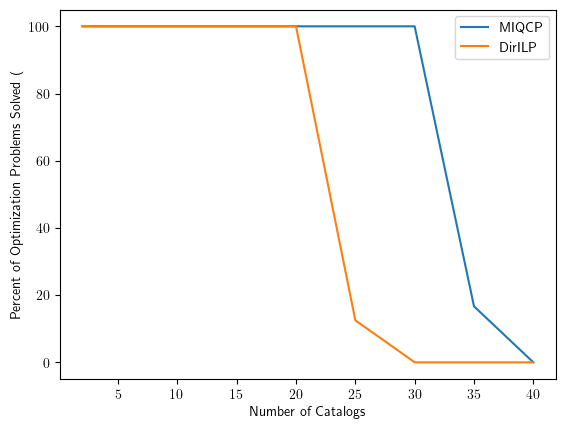

In [58]:
plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Percent of Optimization Problems Solved (%)")
cats = list(miqcp_percent_solved.keys())
plt.plot(cats, [v for v in miqcp_percent_solved.values()])
plt.plot(cats, [v for v in dirilp_percent_solved.values()])
plt.legend(["MIQCP", "DirILP"])
plt.savefig("percent_solved_long.svg")

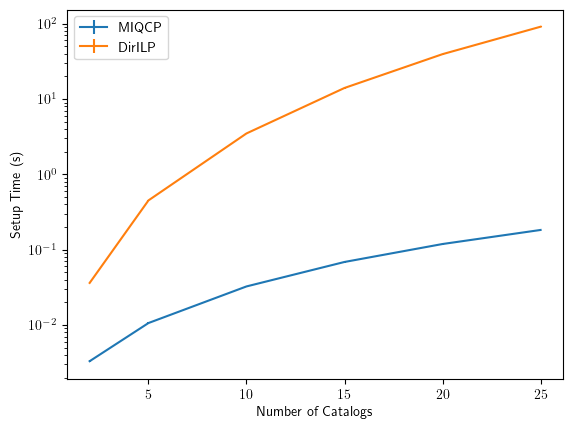

In [60]:
setuptimes = pd.read_csv("setuptime1.csv", index_col=0)
cat_list = setuptimes["number of catalogs"].unique()
miqcp_setup = setuptimes.groupby('number of catalogs')["miqcp runtime"].apply(list).to_dict()
dirilp_setup = setuptimes.groupby('number of catalogs')["dirilp runtime"].apply(list).to_dict()

miqcp_setup_mean_std = {k:filtered_mean_std(v) for k,v in miqcp_setup.items()}
dirilp_setup_mean_std = {k:filtered_mean_std(v) for k,v in dirilp_setup.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Setup Time (s)")
plot_runtimes_error(miqcp_setup_mean_std)
plot_runtimes_error(dirilp_setup_mean_std)
plt.legend(["MIQCP", "DirILP"])
plt.savefig("setuptimes.svg")

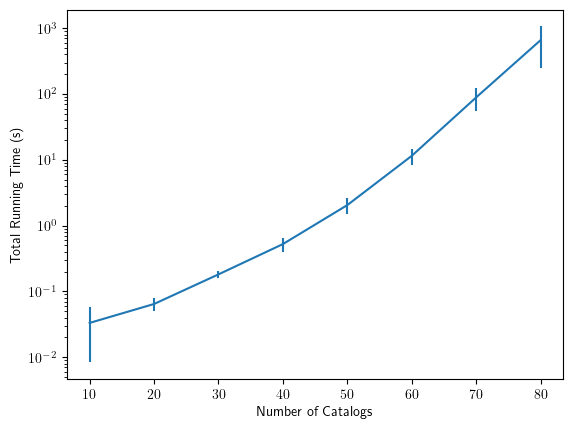

In [5]:
times = pd.read_csv("runtime-capped.csv", index_col=0)
cat_list = times["number of catalogs"].unique()
miqcp_run = times.groupby('number of catalogs')["miqcp runtime"].apply(list).to_dict()

miqcp_mean_std = {k:filtered_mean_std(v) for k,v in miqcp_run.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
plt.savefig("capped-runtime.svg")

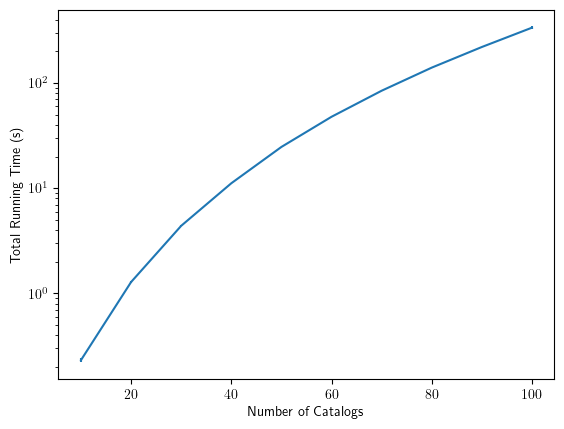

In [4]:
times = pd.read_csv("runtime-copkmeans.csv", index_col=0)
cat_list = times["number of catalogs"].unique()
miqcp_run = times.groupby('number of catalogs')["miqcp runtime"].apply(list).to_dict()

miqcp_mean_std = {k:filtered_mean_std(v) for k,v in miqcp_run.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
plt.savefig("capped-copkmeans.svg")

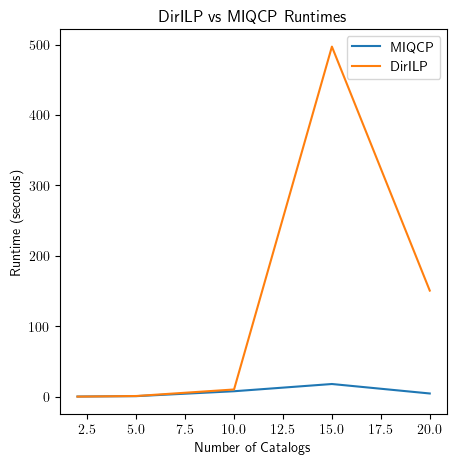

In [42]:
runtimes = pd.read_csv("runtimes2.csv")
times = runtimes["miqcp runtimes"]
miqcp_runtimes = [t.strip('][').split(', ') for t in times]
miqcp_runtimes = [float(t[0]) for t in miqcp_runtimes]

times = runtimes["dirilp runtimes"]
dirilp_runtimes = [t.strip('][').split(', ') for t in times]
dirilp_runtimes = [float(t[0]) for t in dirilp_runtimes]

for i in range(len(dirilp_runtimes)):
    if dirilp_runtimes[i] == 1000000000:
        dirilp_runtimes[i] = np.nan

plt.figure(figsize=(5,5))
plt.title("DirILP vs MIQCP Runtimes")
plt.plot(runtimes["number of catalogs"][:-2], miqcp_runtimes[:-2])
plt.plot(runtimes["number of catalogs"][:-2], dirilp_runtimes[:-2])
plt.legend(["MIQCP", "DirILP"])
plt.xlabel("Number of Catalogs")
plt.ylabel("Runtime (seconds)")
plt.savefig("runtime_short_2.svg")